# Working Geospatial Data: Raster Data 1: Hypsometric Curve

Raster data are perhaps the most conceptually straightforward form of geospatial data. A raster is simply a 2-dimensional gridded dataset situated somewhere on the surface of the Earth (or someother planetoid). To situate the grid, we need to know some important data such as: (1) the spatial coordinates of at least one pixel in an appropriate coordinate reference system (CRS) - usually the lower left one, (2) the number of rows and columns in the raster, (3) size of each pixel – most often each pixel will be equal size in x- and y-coordinates, but this doesn't have to be true, and (3) some number that tells us what data within the grid should be considered as not valid (i.e., a no-data value like -9999). There are a lot of nuances to this that are more appropriately dealt with in a GIS class. Things like rectilinear vs. curvilinear grids, appropriate CRSs and their transformations, and data storage conventions that might apply a scale factor and offset to store the data more efficiently. 

In this class, we're most interested in tools that allow us to analyze pre-prepared gridded datasets that encompass data like elevation and/or landcover. In this notebook, we will use a popular library called [rasterio](https://rasterio.readthedocs.io/en/stable/) to read in and analyze a digital elevation model (DEM) and land use/land cover for the Upper Boise River Basin (UBRB). If you're interested, I prepared and downloaded these data using Google Earth Engine, which has a great Python API. 

We'll start by loading the appropriate libraries. In this notebook, most of the libraries are standard ones we've used beflore. But `mpl_toolkits` provides us some advanced tools for manipulating Matplotlib plots, and `pygeohydro` is a somewhat bespoke library that gives us the standard National Land Cover Dataset (NLCD) colormap for land use.

In the notebook below, we will simply look at the land use/land cover and then compute and plot the so-called hypsometric curve of the UBRB – the proportion of a map at a particular elevation for all elevations. We will then use these plots to pose some additional questions we might want to ask. 

__Note:__ The GeoTiff data for this notebook can be found in [this Google Drive folder](https://drive.google.com/drive/folders/10zgh9vo9t2vGCMVmxl_zOzz9aT58_dMD?usp=sharing). Download it and copy it to a folder that you can reference below in the code. 

In [1]:
import numpy as np
import rasterio as rio # reads in data; library to recognize raster data 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # sub toolbox of matplotlib with rigid control on axes - stylistic thing 
import pygeohydro as gh # for pretty colormap 

elev_fname = '../data/ubrb_dem_30m.tif'
lulc_fname = '../data/upper_boise_landcover_30m.tif'
# elev_fname = '../data/hfork_dem_30m.tif' # henrys fork east ID and WY
# lulc_fname = '../data/hfork_lulc_30m.tif'

plot_label = 'Upper Boise River'
# plot_label = 'Upper Snake River'

In [ ]:
# elevation data
elev_data = rio.open(elev_fname)
elev_array = elev_data.read(1) # read in first band
elev_array.shape

(3239, 5433)

In [4]:
print(type(elev_data))
print(type(elev_array))

<class 'rasterio.io.DatasetReader'>
<class 'numpy.ndarray'>


In [ ]:
elev_data.crs # coordinate reference system;
# wkt = well known text; standard format to communicate coordinate reference systems
# there is a tool paackage to convert between coordinate reference systems.

CRS.from_wkt('GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4269"]]')

In [ ]:
# Lannd use data
lulc_data = rio.open(lulc_fname)
lulc_array = lulc_data.read(1)
lulc_array.shape

(3239, 5433)

In [7]:
elev_data.crs

CRS.from_wkt('GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4269"]]')

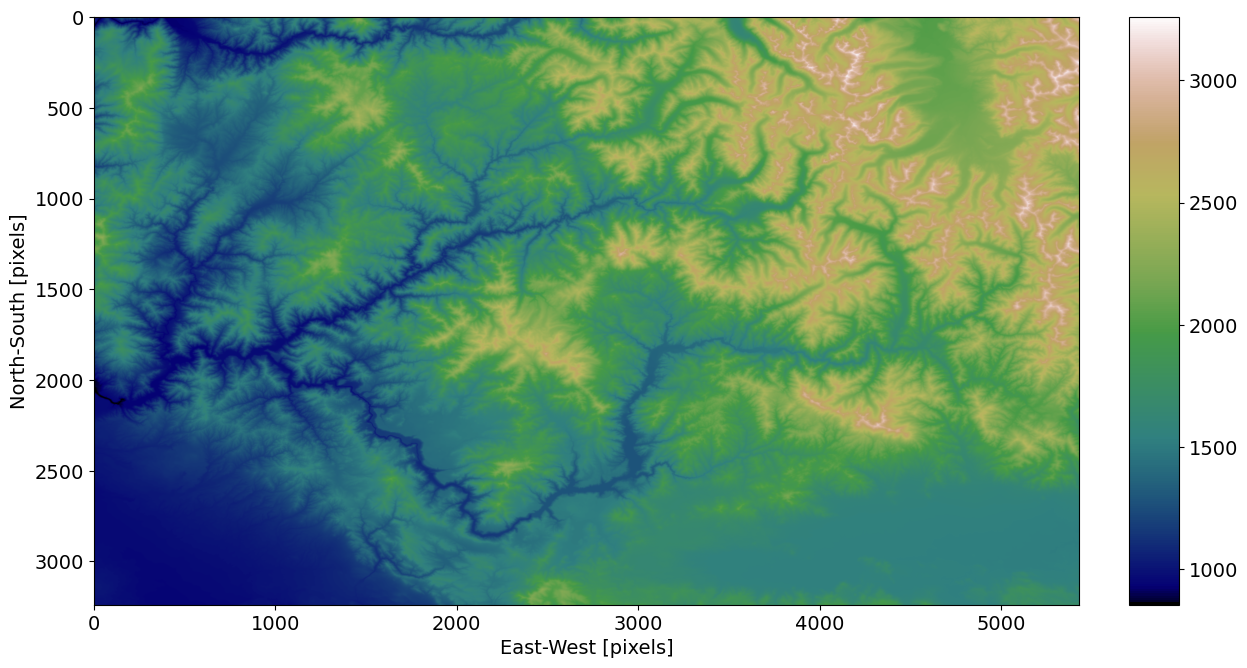

In [10]:
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize = (14,8))
im = ax.imshow(elev_array,cmap='gist_earth') # image show - shows the image ; # cmap = color map 'gist earth'
ax.set_xlabel('East-West [pixels]')
ax.set_ylabel('North-South [pixels]')
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size = '5%', pad = 0.5, pack_start = False)
fig.add_axes(cax)
fig.colorbar(mappable=im, cax=cax)

plt.show()

In [11]:
zmin = elev_array.min()
zmax = elev_array.max()
zmean = elev_array.mean()
zstd = elev_array.std()

zstats = f'''
Elevation Statistics:
Minimum elevation: {zmin:.{2}f} m
Maximum elevation: {zmax:.{2}f} m
Mean elevation: {zmean:.{2}f} m
Std. dev. elevation: {zstd:.{2}f} m
'''

print(zstats)


Elevation Statistics:
Minimum elevation: 853.23 m
Maximum elevation: 3259.66 m
Mean elevation: 1797.45 m
Std. dev. elevation: 476.46 m



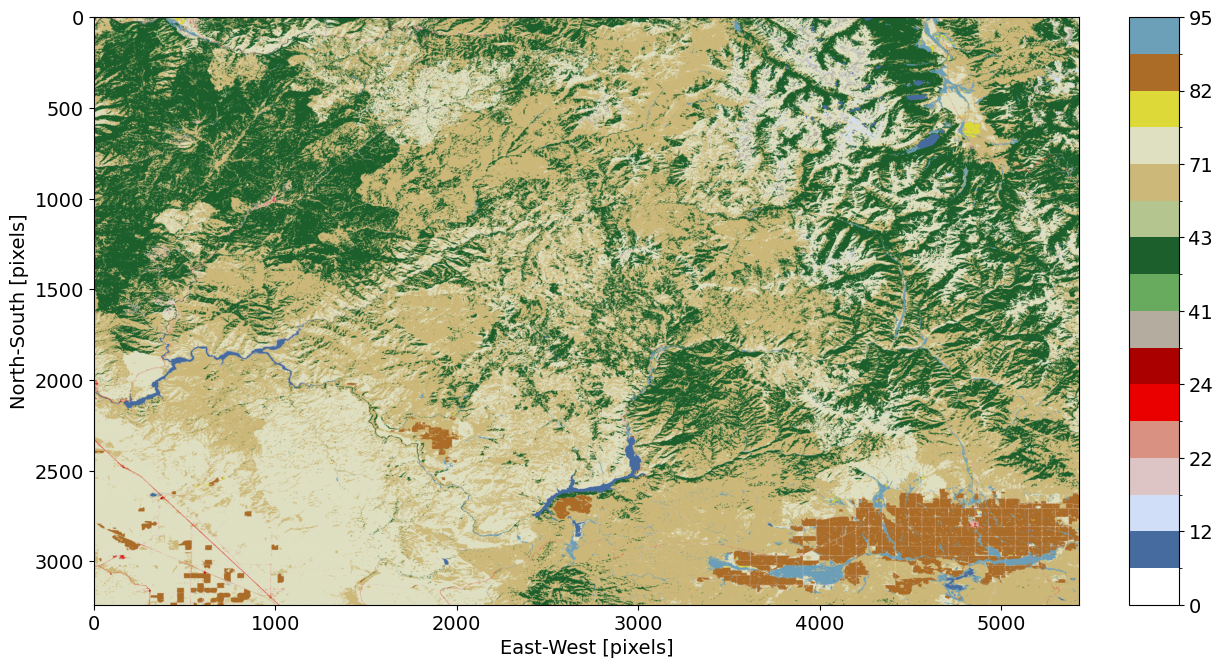

In [12]:
# Get NLCD colormap using pygeohydro tool stack 
cmap, norm, levels = gh.plot.cover_legends()

fig, ax = plt.subplots(figsize = (14,8))
im = ax.imshow(np.flipud(lulc_array),cmap=cmap, norm=norm)
ax.set_xlabel('East-West [pixels]')
ax.set_ylabel('North-South [pixels]')
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size = '5%', pad = 0.5, pack_start = False)
fig.add_axes(cax)
fig.colorbar(mappable=im, cax=cax)

plt.show()

In [ ]:
# Histogram of elevations and bin centers, fractino of area at each elevation
zhist, zbins = np.histogram(elev_array, bins=25)
zbin_center = (zbins[:-1] + zbins[1:])/2
zfrac = zhist/zhist.sum()

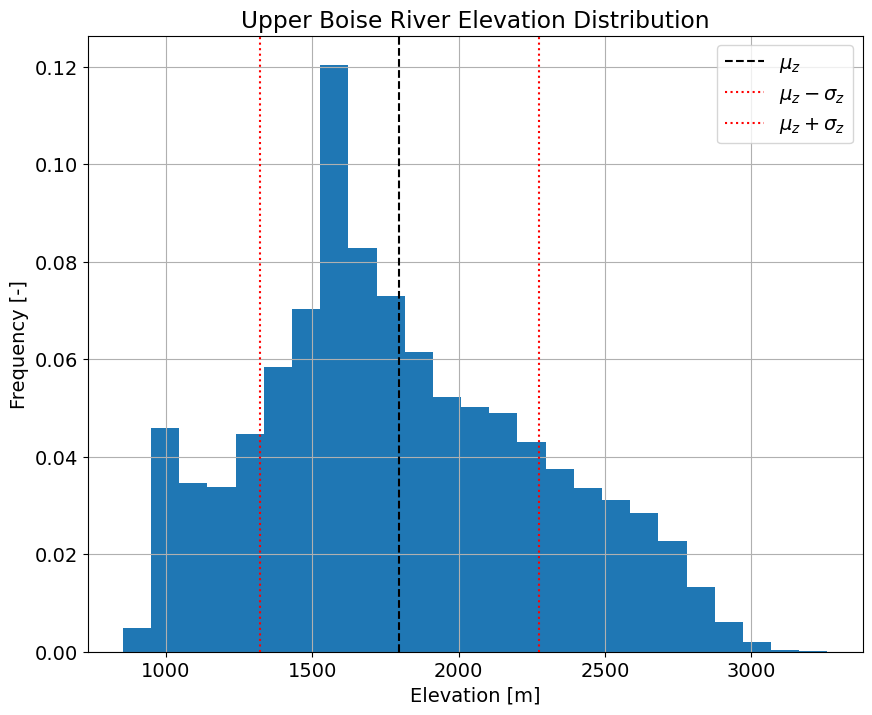

In [14]:
plt.figure(figsize=(10,8))
plt.bar(zbin_center,zfrac,width=1.0*(zbin_center[1]-zbin_center[0]))
plt.axvline(zmean, color='k', linestyle='--', label=r'$\mu_z$')
plt.axvline(zmean-zstd, color='r', linestyle=':', label=r'$\mu_z - \sigma_z$')
plt.axvline(zmean+zstd, color='r', linestyle=':', label=r'$\mu_z + \sigma_z$')
plt.title(plot_label+' Elevation Distribution')
plt.xlabel('Elevation [m]')
plt.ylabel('Frequency [-]')
plt.grid('on')
plt.legend()
plt.show()

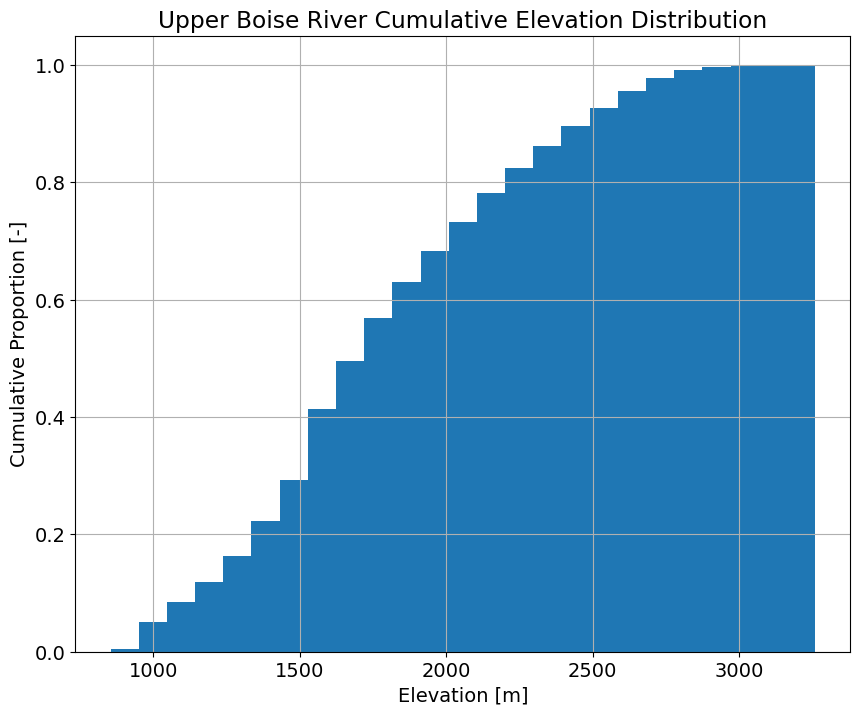

In [15]:
plt.figure(figsize=(10,8))
plt.bar(zbin_center,zfrac.cumsum(),width=1.0*(zbin_center[1]-zbin_center[0]))
plt.title(plot_label+' Cumulative Elevation Distribution')
plt.xlabel('Elevation [m]')
plt.ylabel('Cumulative Proportion [-]')
plt.grid('on')
plt.show()

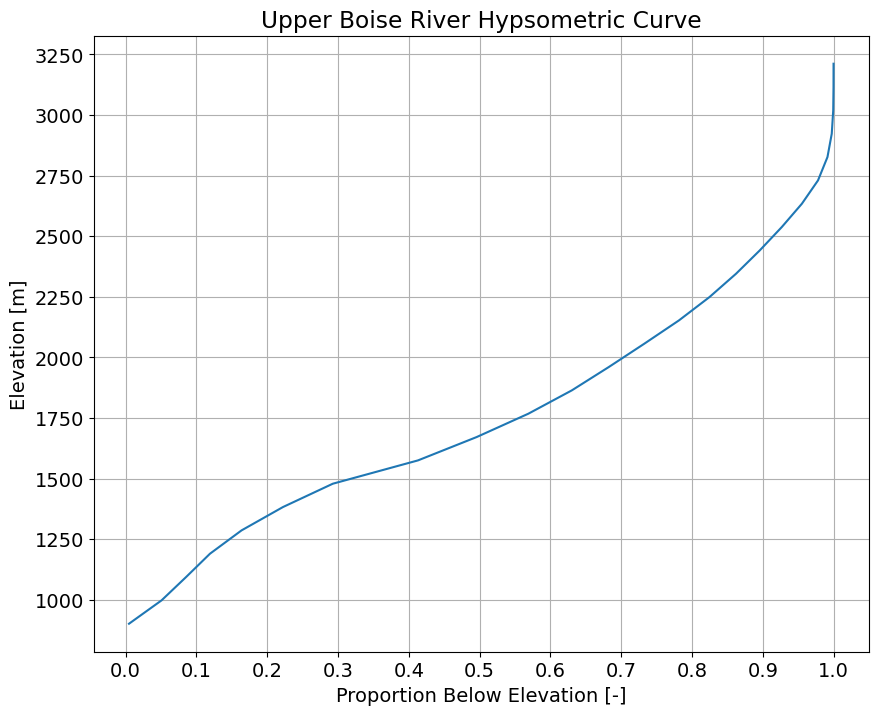

In [16]:
plt.figure(figsize=(10,8))
plt.plot(zfrac.cumsum(),zbin_center)
plt.xticks(np.arange(0.0, 1.1, 0.1))
plt.yticks(np.arange(1000,3500,250))
plt.title(plot_label+' Hypsometric Curve')
plt.xlabel('Proportion Below Elevation [-]')
plt.ylabel('Elevation [m]')
plt.grid('on')
plt.show()

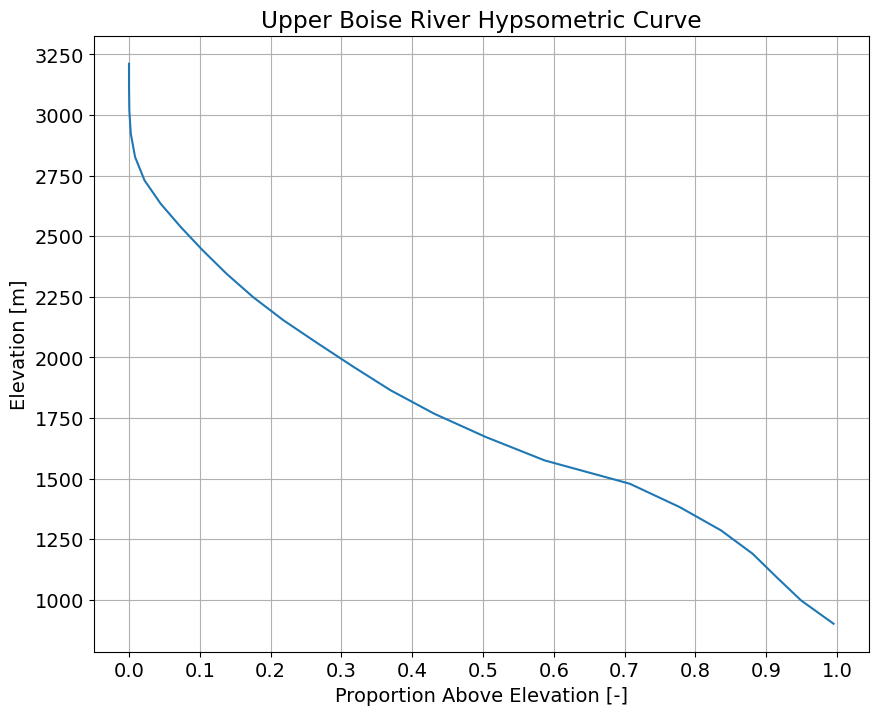

In [17]:
plt.figure(figsize=(10,8))
plt.plot(1.0 - zfrac.cumsum(),zbin_center)
plt.xticks(np.arange(0.0, 1.1, 0.1))
plt.yticks(np.arange(1000,3500,250))
plt.title(plot_label+' Hypsometric Curve')
plt.xlabel('Proportion Above Elevation [-]')
plt.ylabel('Elevation [m]')
plt.grid('on')
plt.show()

## questions we can ask with this data
- what elevations bands what is the distribution of land cover?
- compute slope and compare to land cover 
- compare aspect 
- compare watersheds
    - clip the watershed raster polygon 